<a href="https://colab.research.google.com/github/harperd17/energy_volatility_prediction/blob/main/notebooks/Data%20Ingestion/Weather_Data_Ingestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install us
!pip install geopandas
!pip install raster2xyz
import geopandas
import us
import ee
from IPython.display import Image
from google.colab import drive
import json
import time
import matplotlib.pyplot as plt
import pandas as pd
from raster2xyz.raster2xyz import Raster2xyz
from osgeo import gdal
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from shapely.geometry import shape, Point

     |████████████████████████████████| 132 kB 9.1 MB/s 
  Created wheel for us: filename=us-2.0.2-py3-none-any.whl size=11942 sha256=2c31a9a55fafb266588370d1b95904e1cb9230457bc0e0cf75012d0fa785fcad
  Stored in directory: /root/.cache/pip/wheels/ca/6b/11/cda9ea2438f721330a35c9a2c8e34b4aedcd34c89af48a4d00
  Created wheel for jellyfish: filename=jellyfish-0.6.1-cp37-cp37m-linux_x86_64.whl size=72184 sha256=ece9f966cd6fc8b3e519538d4a0334879c3d7e0353cf340102b7cc566e55b64d
  Stored in directory: /root/.cache/pip/wheels/a1/99/51/7de469e37cd1b3c763c24394e1ebf1baa2d79e094bf346cf80
Successfully built us jellyfish
     |████████████████████████████████| 1.0 MB 7.4 MB/s 
     |████████████████████████████████| 15.4 MB 39 kB/s 
     |████████████████████████████████| 6.3 MB 38.0 MB/s 
  Created wheel for raster2xyz: filename=raster2xyz-0.1.3-py3-none-any.whl size=5965 sha256=a93136c5fd39cba3f002c030bae863bce9e8f001ca32f11c8ce8099c45842577
  Stored in directory: /root/.cache/pip/wheels/07/4b/5d/fc6

Source on using Earth Engine:
https://colab.research.google.com/github/google/earthengine-community/blob/master/tutorials/intro-to-python-api-guiattard/index.ipynb|

In [ ]:
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=-R8-xFWCdMi7ctzD4cXnJaei0pbF9D9Ga7OA2pLO_EE&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWiydW-48PccxGSBD-22gTZDM3cJXsSOq6OMds5s3boYSVraomIDjUY

Successfully saved authorization token.


In [ ]:
ee.Initialize()

#### I got a geojson file from this link <link><https://eric.clst.org/tech/usgeojson/> for the state outlines. This will be used for querying from Earth Engine

In [ ]:
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
%cd /content/drive/Shareddrives/Data606_Energy/data/weather

/content/drive/Shareddrives/Data606_Energy/data/weather


## Get the US geojson outline and the state geojson outlines

In [ ]:
with open('gz_2010_us_040_00_20m.json') as state_outlines_file:
  state_outlines = json.load(state_outlines_file)

In [ ]:
data = geopandas.read_file("https://raw.githubusercontent.com/johan/world.geo.json/master/countries/USA.geo.json")

In [ ]:
data.head()

,id,name,geometry
0,USA,United States of America,"MULTIPOLYGON (((-155.54211 19.08348, -155.6881..."


In [ ]:
all_us_polygons = []
for poly in data['geometry'][0].geoms:
  x, y = poly.exterior.coords.xy
  all_us_polygons.append([[[x[i],y[i]] for i in range(len(x))]])

In [ ]:
us_polygon = ee.Geometry.MultiPolygon(all_us_polygons)

In [ ]:
states_coordinates = {}
ee_state_polygons = {}
for geom in state_outlines['features']:
  # get the abbreviation of the state before storing the coordinates
  geom_state = geom['properties']['NAME']
  state_object = us.states.lookup(geom_state)
  ee_state_polygons[state_object.abbr] = ee.Geometry.MultiPolygon(geom['geometry']['coordinates'],None, False)
  states_coordinates[state_object.abbr] = geom['geometry']['coordinates']

In [ ]:
#this function is used to figure out which coordinates are within a polygon
def determine_within(coords,polygon):
  within = []
  for c in coords:
    p = Point(c[0],c[1])
    if polygon.contains(p):
      within.append(True)
    else:
      within.append(False)
  return within

In [ ]:
# this function finds what states the data points belong to
def add_states_to_data(geojson, data):
  coordinates = [[data['x'].iloc[i], data['y'].iloc[i]] for i in range(data.shape[0])]
  data['State'] = [np.nan]*data.shape[0]
  shapely_polies = []
  states = []
  for p in geojson['features']:
    shapely_polies.append(shape(p['geometry']))
    states.append(p['properties']['NAME'])
  # now loop all the coordinates through these polygons and find which ones belong where
  for i, state_shape in enumerate(shapely_polies):
    coordinates_within_state = determine_within(coordinates, state_shape)
    data['State'].iloc[np.where(coordinates_within_state)] = states[i]
  return data

In [ ]:
!pip install pyproj
import pyproj

In [ ]:
def create_radius_buffer(coordinates, buffer_radius, points_in_circle):
  # coordinates = coordinate_pair 
  # buffer_radius = radius 
  # points_in_circle = 600
  geodesic = pyproj.Geod(ellps='WGS84')
  lon = coordinates [1]
  lat = coordinates [0]
  semi_circle_coords = []
  increment = 360/points_in_circle
  for a in np.arange(0,360+increment, increment):
    semi_circle_coords.append(geodesic.fwd(lons = lon, lats = lat, az = a, dist = buffer_radius)[:2])
  semi_circle_coords.append(semi_circle_coords[0])
  polygon = shape({'type':"Polygon",'coordinates':[semi_circle_coords]})
  return polygon, semi_circle_coords

In [ ]:
# this function finds what states the data points belong to
def get_data_population_density(raster_data, data, radius):
  # raster_data = pop_data_pd 
  # data = temperature_data_pd 
  # radius = 30000
  coordinates = [[data['y'].iloc[i], data['x'].iloc[i]] for i in range(data.shape[0])]
  # for each coordinate, I need to draw a circle of radius "radius" around it. these circles will be used to do a 
  # spatial join of the population density layer and take the average of the population density
  all_coordinates_from_within = []
  return_coords = []
  for coordinate_pair in coordinates:
    buffer_radius_polygon, coords = create_radius_buffer(coordinate_pair, radius, 600)
    return_coords.append(coords)
    # find the minimum and maximum latitude and longitude of the polygon
    min_x = np.array(coords)[:,0].min()
    max_x = np.array(coords)[:,0].max()
    min_y = np.array(coords)[:,1].min()
    max_y = np.array(coords)[:,1].max()
    # find the coordinates of the raster data that are within the polygon, but send in a subset of the raster data using the min and maxes set above
    raster_subset = raster_data[(raster_data['x'].between(min_x-0.01,max_x+0.01)) & (raster_data['y'].between(min_y-0.01,max_y+0.01))][['x','y']]
    coordinates_within_polygon = determine_within(np.array(raster_subset), buffer_radius_polygon)
    all_coordinates_from_within.append(list(raster_subset[coordinates_within_polygon].index))
  return all_coordinates_from_within, return_coords

In [ ]:
# does what it says - takes in a geotiff file path and makes it into a csv
def convert_geotiff_to_csv(file_path, output_path, start_date, delta, geojson, add_state):
  ds = gdal.Open(file_path)
  all_bands = []
  band_names = []
  data = {}
  # loop through each band
  print("There are {} dates of data".format(ds.RasterCount))
  for bi in range(ds.RasterCount):
      band = ds.GetRasterBand(bi + 1)
      #band_names.append(band.GetDescription())
      band_names.append(start_date)
      data[band.GetDescription()] = []
      # Read this band into a 2D NumPy array
      ar = band.ReadAsArray()
      all_bands.append(ar)
      start_date += delta
  x_range = len(all_bands[0])
  y_range = len(all_bands[0][0])
  # get the transform of the geotiff so we can get the coordinates of each pixel
  transform = ds.GetGeoTransform()
  xOrigin = transform[0]
  yOrigin = transform[3]
  pixelWidth = transform[1]
  pixelHeight = -transform[5]
  x_coordinates = np.arange(y_range)*pixelWidth+xOrigin
  y_coordinates = (np.arange(x_range)*pixelHeight-yOrigin)*-1
  all_coords = [(y,x) for y in y_coordinates for x in x_coordinates]
  # create a dictionary of data per band of data and make a pandas dataframe
  new_data = {}
  for i, band in enumerate(all_bands):
    new_data[band_names[i]] = np.array(band).flatten()
  new_data_pd = pd.DataFrame(new_data,index=all_coords)
  new_data_pd['y'] = [ind[0] for ind in new_data_pd.index]
  new_data_pd['x'] = [ind[1] for ind in new_data_pd.index]
  if add_state:
    # now add the state of each coordinate to the data
    new_data_pd = add_states_to_data(geojson,new_data_pd)
    # now that I have the data with associated states, let's subset the data to coordinates that
    # within the US (the rest should be N/A anyway)
    new_data_pd = new_data_pd[~new_data_pd['State'].isnull()]
  else:
    new_data_pd = new_data_pd.dropna()
  # save the dataframe to a csv file
  new_data_pd.to_csv(output_path)
  return new_data_pd

In [ ]:
state_poly = us_polygon # querying the entire US

## Get Temperature Data

In [ ]:
granularity = 60000 # 60,000 m, so 60 km

In [ ]:
date = ['1981-01-01','2021-10-01'] # range of dates to gather data for

In [ ]:
temp = ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY').select('temperature_2m').filter(ee.Filter.date(date[0],date[1]))#NASA/ORNL/DAYMET_V4 # OREGONSTATE/PRISM/AN81d # ECMWF/ERA5_LAND/MONTHLY
new_temp = temp.toBands().clip(state_poly)

task = ee.batch.Export.image.toDrive(image=new_temp,
                                    region = state_poly,
                                    scale = granularity,
                                    description='temp_layer'+date[0]+"-"+date[1],
                                    folder = './', # I could never get this to actually save to a specified folder
                                    fileNamePrefix='temp_layer'+date[0]+"-"+date[1],
                                    crs='EPSG:4326',
                                    fileFormat='GeoTiff')
task.start()
#now I'm putting in a while loop to wait until the task is completed and then it will move on to the next date range
completed = False
while not completed:
  if task.status()['state'] == 'COMPLETED':
    print("EXPORT COMPLETED. Onto the next date range")
    completed = True
  else:
    print("Export Not Completed. Waiting 10 more seconds")
    time.sleep(10)

Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
EXPORT COMPLETED. Onto the next date range


In [ ]:
##quick visualization of the temp data for one of the days
Image(url=temp.first().clip(state_poly).getThumbURL({
    'min': 240, 'max': 300, 'dimensions': 512, 'region': state_poly,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

In [ ]:
temperature_data_pd = convert_geotiff_to_csv('temp_layer{}-{}.tif'.format(date[0],date[1]), 'temperatures_{}-{}.csv'.format(date[0],date[1]),datetime(year=1981,month=1,day=1),relativedelta(months=1),state_outlines,add_state=True)

There are 486 dates of data


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
temperature_data_pd.shape

(3776, 489)

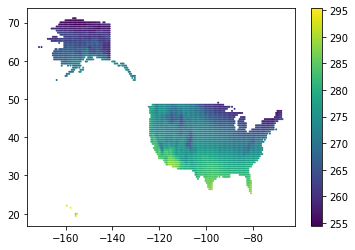

In [ ]:
# confirm that the data looks correct
plt.scatter(temperature_data_pd['x'],temperature_data_pd['y'],c=temperature_data_pd[temperature_data_pd.columns[0]],s=1)
plt.colorbar()

## Get the Drought Data

In [ ]:
temp = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE').select('pdsi').filter(ee.Filter.date(date[0],date[1]))# GRIDMET/DROUGHT
new_temp = temp.toBands().clip(state_poly)

task = ee.batch.Export.image.toDrive(image=new_temp,
                                    region = state_poly,
                                    scale = granularity,
                                    description='pdsi_layer'+date[0]+"-"+date[1],
                                    folder = './',
                                    fileNamePrefix='pdsi_layer'+date[0]+"-"+date[1],
                                    crs='EPSG:4326',
                                    fileFormat='GeoTiff')
task.start()
#now I'm putting in a while loop to wait until the task is completed and then it will move on to the next date range
completed = False
while not completed:
  if task.status()['state'] == 'COMPLETED':
    print("EXPORT COMPLETED. Onto the next date range")
    completed = True
  else:
    print("Export Not Completed. Waiting 10 more seconds")
    time.sleep(10)

Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
EXPORT COMPLETED. Onto the next date range


In [ ]:
drought_data_pd = convert_geotiff_to_csv('pdsi_layer{}-{}.tif'.format(date[0],date[1]), 'pdsi_{}-{}.csv'.format(date[0],date[1]),datetime(year=1981,month=1,day=1),relativedelta(months=1),state_outlines, add_state=True)

There are 480 dates of data


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
drought_data_pd.shape

(3776, 483)

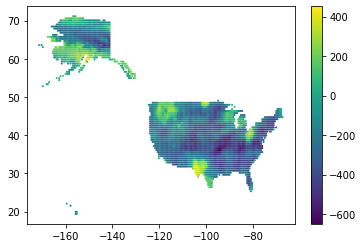

In [ ]:
# confirm that the data looks correct
plt.scatter(drought_data_pd['x'],drought_data_pd['y'],c=drought_data_pd[drought_data_pd.columns[0]],s=1)
plt.colorbar()

## Get Population Density Data

In [ ]:
pop = ee.ImageCollection('CIESIN/GPWv411/GPW_Population_Density').select('population_density').filter(ee.Filter.date('1999-01-01','2001-01-01')).first()
new_pop = pop.clip(state_poly)

task = ee.batch.Export.image.toDrive(image=new_pop,
                                    region = state_poly,
                                    scale = 5000,#927.67,
                                    description='pop_layer',
                                    folder = './', # I could never get this to actually save to a specified folder
                                    fileNamePrefix='pop_layer',
                                    crs='EPSG:4326',
                                    fileFormat='GeoTiff')
task.start()
#now I'm putting in a while loop to wait until the task is completed and then it will move on to the next date range
completed = False
while not completed:
  if task.status()['state'] == 'COMPLETED':
    print("EXPORT COMPLETED")
    completed = True
  else:
    print("Export Not Completed. Waiting 10 more seconds")
    time.sleep(10)

Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
Export Not Completed. Waiting 10 more seconds
EXPORT COMPLETED


In [ ]:
##quick visualization of the temp data for one of the days
Image(url=pop.clip(state_poly).getThumbURL({
    'min': 0, 'max': 2500, 'dimensions': 512, 'region': state_poly,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

In [ ]:
pop_data_pd = convert_geotiff_to_csv('pop_layer.tif', 'population_density.csv',datetime(year=2015,month=1,day=1),relativedelta(months=1),state_outlines, add_state = False)

There are 1 dates of data


In [ ]:
def get_pop_to_other(pop_data_pd,other_data_pd,radius):
  # get the population density coordinates that are within the buffer of given radius of each weather data coordinate
  pop_coordinates, radius_coords = get_data_population_density(pop_data_pd, other_data_pd, radius)
  # for each weather data coordinate, I need to get the average population density
  mean_population_densities = []
  pop_column = pop_data_pd.columns[0]
  for pop_coord_set in pop_coordinates:
    mean_population_densities.append(pop_data_pd.loc[pop_coord_set][pop_column].mean())
  pop_densities_at_other_coords = pd.DataFrame({'Average Density':mean_population_densities,'y':other_data_pd['y'],'x':other_data_pd['x']})
  return pop_densities_at_other_coords, pop_coordinates, radius_coords

## Get the Population Density Averages at the Temperature Coordinates

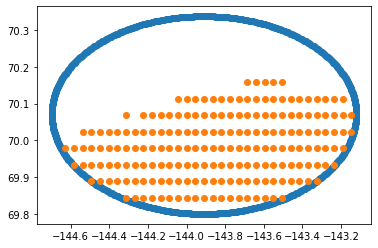

In [ ]:
pop_densities_at_temperature_coords, all_coordinates_from_within, return_coords = get_pop_to_other(pop_data_pd,temperature_data_pd,30000)
# check a sample set of pairs to ensure it looks correct in relation to the buffer radius
ind = 50
plt.scatter(np.array(return_coords[ind])[:,0],np.array(return_coords[ind])[:,1])
plt.scatter(pop_data_pd.loc[all_coordinates_from_within[ind]]['x'],pop_data_pd.loc[all_coordinates_from_within[ind]]['y'])

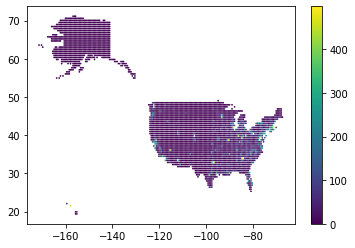

In [ ]:
pop_subset = pop_densities_at_temperature_coords[pop_densities_at_temperature_coords['Average Density']<500]
plt.scatter(pop_subset['x'], pop_subset['y'], c=pop_subset['Average Density'],s=0.5)
plt.colorbar()

In [ ]:
# save the results
pop_densities_at_temperature_coords.to_csv('population_density_at_temperature_coordinates.csv')

## Get the Population Density Averages at the Drought Coordinates

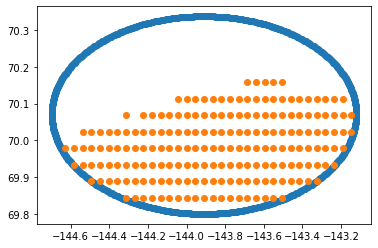

In [ ]:
pop_densities_at_drought_coords, all_coordinates_from_within, return_coords = get_pop_to_other(pop_data_pd,drought_data_pd,30000)
# check a sample set of pairs to ensure it looks correct in relation to the buffer radius
ind = 50
plt.scatter(np.array(return_coords[ind])[:,0],np.array(return_coords[ind])[:,1])
plt.scatter(pop_data_pd.loc[all_coordinates_from_within[ind]]['x'],pop_data_pd.loc[all_coordinates_from_within[ind]]['y'])

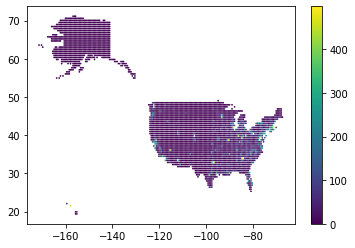

In [ ]:
pop_subset = pop_densities_at_drought_coords[pop_densities_at_drought_coords['Average Density']<500]
plt.scatter(pop_subset['x'], pop_subset['y'], c=pop_subset['Average Density'],s=0.5)
plt.colorbar()

In [ ]:
# save the results
pop_densities_at_drought_coords.to_csv('population_density_at_drought_coordinates.csv')

# The code below isn't actually used - it was so much data for the ammount of locations we have and is only available at the daily level. After 3 days, one year of data still hasn't finished exporting.

## Get Cloud Coverage Data

In [ ]:
#date = ['2001-01-01','2021-01-01'] # range of dates to gather data for
all_dates = []
for year in range(2001,2022):
  all_dates.append([f'{year}-01-01',f'{year+1}-01-01'])

In [ ]:
all_dates

[['2001-01-01', '2002-01-01'],
 ['2002-01-01', '2003-01-01'],
 ['2003-01-01', '2004-01-01'],
 ['2004-01-01', '2005-01-01'],
 ['2005-01-01', '2006-01-01'],
 ['2006-01-01', '2007-01-01'],
 ['2007-01-01', '2008-01-01'],
 ['2008-01-01', '2009-01-01'],
 ['2009-01-01', '2010-01-01'],
 ['2010-01-01', '2011-01-01'],
 ['2011-01-01', '2012-01-01'],
 ['2012-01-01', '2013-01-01'],
 ['2013-01-01', '2014-01-01'],
 ['2014-01-01', '2015-01-01'],
 ['2015-01-01', '2016-01-01'],
 ['2016-01-01', '2017-01-01'],
 ['2017-01-01', '2018-01-01'],
 ['2018-01-01', '2019-01-01'],
 ['2019-01-01', '2020-01-01'],
 ['2020-01-01', '2021-01-01'],
 ['2021-01-01', '2022-01-01']]

In [ ]:
df_powerplant = pd.read_csv("../eda_ready/energy_plant_net_generation.csv")

df_powerplant_solar = df_powerplant.query('fuel_type == "SUN"')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_powerplant_solar['date'] = pd.to_datetime(df_powerplant_solar['date'],format='%Y-%m-%d')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
dates_to_get_data_for = pd.date_range(start=df_powerplant_solar['date'].min(),end=df_powerplant_solar['date'].max())

In [ ]:
unique_plants = df_powerplant_solar['plant_code'].unique()

In [ ]:
len(unique_plants)

3238

In [ ]:
def download_cloud_data(point_buffer, dates, scale, plant_code):
  cloud = ee.ImageCollection('NOAA/GOES/16/MCMIPF').filter(ee.Filter.date(dates[0], dates[1]))
  new_cloud = cloud.toBands().clip(point_buffer)

  task = ee.batch.Export.image.toDrive(image=new_cloud,
                                      region = point_buffer,
                                      scale = scale,
                                      description='cloud_layer',
                                      folder = 'cloud_layer'+str(dates[0])+str(dates[1]), # I could never get this to actually save to a specified folder
                                      fileNamePrefix='cloud_layer',
                                      crs='EPSG:4326',
                                      fileFormat='GeoTiff')
  task.start()
  #now I'm putting in a while loop to wait until the task is completed and then it will move on to the next date range
  completed = False
  while not completed:
    if task.status()['state'] == 'COMPLETED':
      print("EXPORT COMPLETED")
      completed = True
    else:
      print(task.status()['state'])
      print("Export Not Completed. Waiting 10 more seconds")
      time.sleep(10)

In [ ]:
buffer_radius = 10000 #10 km
coords = []

for plant in unique_plants:
  lat = df_powerplant_solar.query('plant_code=='+str(plant))['lat'].iloc[0]
  lon = df_powerplant_solar.query('plant_code=='+str(plant))['lon'].iloc[0]
  coords.append([lon,lat])

In [ ]:
# for i, point in enumerate(coords[:1000]):
#   download_cloud_data(ee.Geometry.Point(coords=point),[dates_to_get_data_for[0],dates_to_get_data_for[-1]],1000, unique_plants[i])

In [ ]:
ee_multi_point = ee.Geometry.MultiPoint(coords=coords)
#ee_buffer = ee_multi_point.buffer(buffer_radius)

# now query for the point for the dates
download_cloud_data(ee_multi_point,[dates_to_get_data_for[0],dates_to_get_data_for[-1]],100000, 'na')

READY
Export Not Completed. Waiting 10 more seconds
READY
Export Not Completed. Waiting 10 more seconds
READY
Export Not Completed. Waiting 10 more seconds
READY
Export Not Completed. Waiting 10 more seconds
READY
Export Not Completed. Waiting 10 more seconds
READY
Export Not Completed. Waiting 10 more seconds
READY
Export Not Completed. Waiting 10 more seconds
READY
Export Not Completed. Waiting 10 more seconds
READY
Export Not Completed. Waiting 10 more seconds
READY
Export Not Completed. Waiting 10 more seconds
READY
Export Not Completed. Waiting 10 more seconds
READY
Export Not Completed. Waiting 10 more seconds
READY
Export Not Completed. Waiting 10 more seconds
READY
Export Not Completed. Waiting 10 more seconds
READY
Export Not Completed. Waiting 10 more seconds
READY
Export Not Completed. Waiting 10 more seconds
READY
Export Not Completed. Waiting 10 more seconds
READY
Export Not Completed. Waiting 10 more seconds
READY
Export Not Completed. Waiting 10 more seconds
READY
Export